In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import math
import random
import numpy as np
import healpy as hp
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy.special import gammaincc
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import *
import pandas as pd
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from probfit import UnbinnedLH, gaussian, Chi2Regression
from NPTFit import create_mask as cm
import astropy.units as u
import astropy.coordinates as coord

import constants_noh as constants
import units

In [2]:
# Setting basic parameters
trials = 10
xsec = 1e-24
marr = [100]
channel = 'b'

nside = 128
npix = hp.nside2npix(nside)
    
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)

In [3]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e2 # [1e10 M_s]
mMin_calib = 1e-2 # [1e10 M_s]
mMax_calib = 1 # [1e10 M_s]
mMin = 1e-5*M_MW # [1e10 M_s]
mMax = 0.01*M_MW # [1e10 M_s]
c_arr = [37.5153, -1.5093, 1.636 * 10**(-2), 3.66 * 10**(-4), -2.89237 * 10**(-5), 5.32 * 10**(-7)] # constants for SP c-m relation
min_flux =1./(np.sum(exposure[~mask])/len(exposure[~mask]))

In [5]:
# Some function
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)
N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos

rho_s2 = N_subs / quad(lambda x: 4*np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( -2./alpha * ( (r/r_s)**(alpha) - 1))

def c200_SP( M200 ): # Sanchez-Conde-Prada mass-concentration relation
    c200_val = 0
    for i in range(6):
        c200_val += c_arr[i] * ( np.log( M200*1e10*units.h ) )**i
    return c200_val

def c200_S( M200, r ): # Distance dependent m-c relation
    alphaR = 0.286
    C1 = 119.75
    C2 = -85.16
    alpha1 = 0.012
    alpha2 = 0.0026
    return (r/402)**(-alphaR) * ( C1*(M200*1e10)**(-alpha1) + C2*(M200*1e10)**(-alpha2))

def myLog(n):
    return np.where( n!=0, np.log10(n), 0)

In [6]:
# Defining arrays necessary for inverse transform
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 10000) # mass values to test
cum_N = np.zeros(len(r_arr)) # CDF
for ir, r in enumerate(r_arr):
    cum_N[ir] = quad(lambda x: 4*np.pi * x**2 * rho_Ein(x), 0, r)[0]
cum_N = cum_N / max(cum_N)
interp_N = np.interp(np.linspace(0,1,N_subs), cum_N, r_arr)

In [7]:
# Particle physics factor

dNdLogx_df = pd.read_csv('Data/AtProduction_gammas.dat', delim_whitespace=True)

ebins = [2,20]
PPnoxsec_arr = np.zeros(len(marr))
for mi in range(len(marr)):
    dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(marr[mi])))))[['Log[10,x]',channel]]
    Egamma = np.array(marr[mi]*(10**dNdLogx_ann_df['Log[10,x]']))
    dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
    dNdE_interp = interp1d(Egamma, dNdEgamma)
    if ebins[0] < marr[mi]:
        if ebins[1] < marr[mi]:
            # Whole bin is inside
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], ebins[1])[0]
        else:
            # Bin only partially contained
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], marr[mi])[0]
PPnoxsec_arr = PPnoxsec_arr

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [8]:
# Integration part of J-Factor
def J_int(M200, r):
    r200 = ( 3 * M200 / (4 * np.pi * 200. * constants.rho_c) )**(1./3.) # Units [kpc]
    rs = r200/c200_S( M200, r ) # Units [kpc]
    rho_0 = M200 / ( 4 * np.pi * rs**3 * (np.log( (rs + r200) / rs) - r200/(rs+r200))) # Units [1e10 M_sun / (kpc)^3]
    return np.pi * rho_0**2 * rs**6 / 3. * ( rs**(-3) - (r200 + rs)**(-3) )

In [9]:
# Creating a mock dataset, calculating F for all subhalos
def get_fluxes():
    mass_arr = np.array(( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*np.random.rand(N_subs))**(-1/.9)) # Subhalo masses
    rval_arr = np.array(interp_N[np.random.randint(1, N_subs, N_subs)]) # Subhalo radii
    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1)) # Subhalo theta, galactocentric coordinates
    phi_arr = (2*np.pi*np.random.rand(N_subs)) # Subhalo phi, galactocentric coordinates

    coords = (coord.Galactocentric(x=rval_arr*np.cos(phi_arr)*np.sin(theta_arr) * u.kpc,
                                  y=rval_arr*np.sin(phi_arr)*np.sin(theta_arr) * u.kpc,
                                  z=rval_arr*np.cos(theta_arr) * u.kpc, 
                                  galcen_distance=constants.r0*u.kpc)).transform_to(coord.Galactic) # Convert to galactic coordinates

    dA_vals = coords.distance.value # Halo-Earth distances
    b_vals = np.radians(coords.b.value) # Subhalo b values
    l_vals = np.radians(coords.l.value) # Subhalo l values
    pixels = hp.ang2pix(nside, np.pi/2.-b_vals, l_vals) # Subhalo pixel numbers

    # Calculate J-factors, convert to correct units
    subhalos_J = J_int(mass_arr, rval_arr)/(dA_vals)**2
    subhalos_J = np.array(subhalos_J) / (units.GeV**2/units.Centimeter**5) * (1e10*units.M_s)**2 * (units.kpc)**(-5)

    J_hist = np.histogram(np.log10(subhalos_J), bins=100)
    subhalos_flux2 = xsec * PPnoxsec_arr[0] * subhalos_J[mask[pixels]]
    hist = np.histogram(subhalos_flux2, bins=np.logspace(-15, -6, 8*8))

    return np.array(hist[0]), mass_arr, rval_arr, theta_arr, phi_arr, dA_vals, b_vals, l_vals, subhalos_J # Save fluxes

In [10]:
# Run get_fluxes for trials number of mock datasets
F_arr = []
for trial in range(trials):
    F_arr.append(get_fluxes()[0])

In [11]:
bins = np.logspace(-15, -6, 8*8)

min_flux_ind = np.argmin(np.abs(bins - min_flux))
min_flux_ind = 0 #TEMPORARY

bins = bins[min_flux_ind:]
F_arr2 = np.array(F_arr)[:,min_flux_ind:]
F_ave = np.mean(F_arr2, axis=0)
dF = np.diff(bins)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2)*len(mask)/(len(mask[mask]))
F = np.array(bins)[:-1]

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


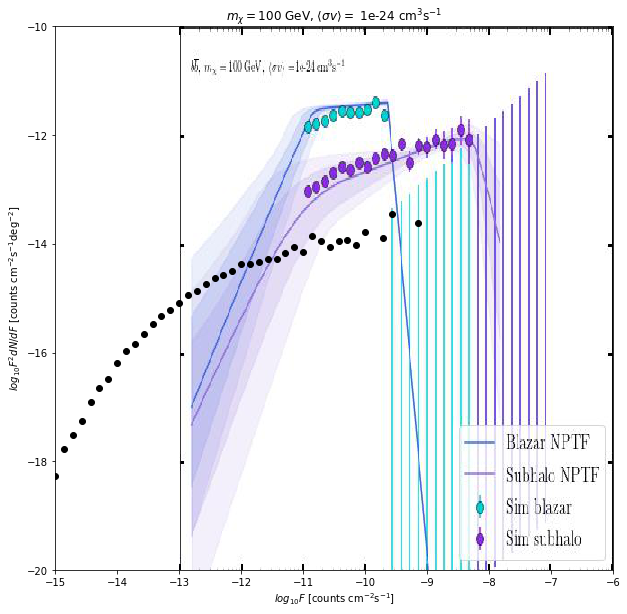

In [12]:
plt.figure(figsize=(10,10))
img = plt.imread("1e-24im.jpg")
plt.imshow(img, extent=[-13,-6,-20,-10], aspect='auto')

plt.errorbar(myLog(F), myLog(F**2 * dN/dF), np.zeros(len(F)), fmt='o', c="black")

plt.ylim(-20, -10)
plt.xlim(-15, -6)
plt.title("$m_{\chi} = 100$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.show()
plt.close()